In [33]:
###### Config #####
import sys, os, platform
if os.path.isdir("ds-assets"):
  !cd ds-assets && git pull
else:
  !git clone https://github.com/lutzhamel/ds-assets.git
colab = True if 'google.colab' in os.sys.modules else False
system = platform.system() # "Windows", "Linux", "Darwin"
home = "ds-assets/assets/"
sys.path.append(home)

Already up to date.


In [34]:
# modules
import pandas as pd
import dsutils
import seaborn as sns; sns.set_theme(rc={'figure.figsize':(4,3)})
from matplotlib.pyplot import show
from statistics import mean
from numpy import percentile
from sklearn.tree import DecisionTreeClassifier
from dsutils import classification_confint
from sklearn.base import clone

# Uncertainty

Uncertainty is omnipresent in machine learning and in data science in general simply because we try to infer properties of a population at large from a small sample of that population.

Consider the Wisconsin breast cancer data set with a few hundred observations.  It represents a tiny fraction of the overall human adult, female population and yet we use this data set to infer the characteristics of cancerous cells and use our machine learning models to predict whether or not a yet undiagnosed cell of an individual not in the training data is cancerous.  Given that the training data represents a tiny sample of the population at large there is some uncertainty connected with any prediction made based on that data.  That is why we predicate any performance claims with a confidence interval acknowledging that there is some uncertainty.

## One Source of Uncertainty

One way to look at the Wisconsin breast cancer data set is as a **sample** of the population at large.  If some other state would conduct a similar study they might create another sample with slightly different characteristics.

Let's study the effect of taking samples by taking samples from our  iris data set.

## Sampling the Iris Dataset

We only use two dimensions and the target attribute of the dataset so that we can easily visualize things.

In [35]:
iris = pd.read_csv(home+"iris.csv")[['Petal.Length', 'Petal.Width','Species']]
iris.head()

,Petal.Length,Petal.Width,Species
0,1.4,0.2,setosa
1,1.4,0.2,setosa
2,1.3,0.2,setosa
3,1.5,0.2,setosa
4,1.4,0.2,setosa


<Axes: xlabel='Petal.Width', ylabel='Petal.Length'>

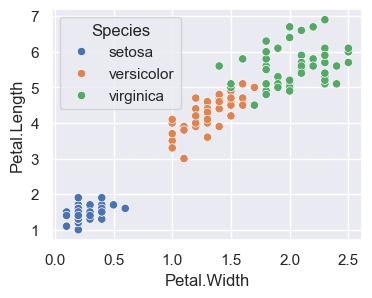

In [36]:
sns.scatterplot(data=iris, 
                x='Petal.Width', 
                y='Petal.Length', 
                hue='Species')

We take samples of size 30 of our iris data. 

In [37]:
sample_size=30

We draw 3 different samples.

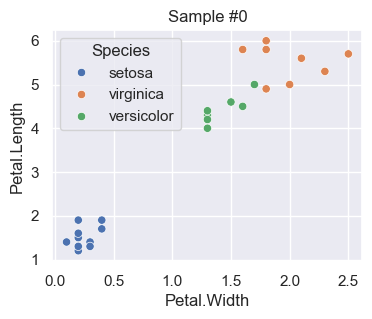

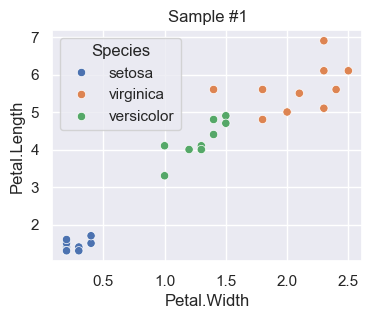

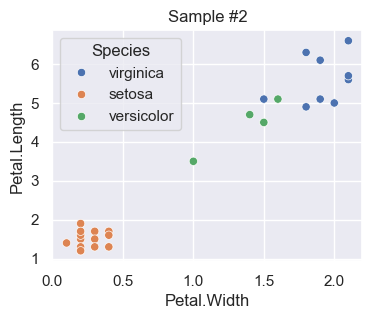

In [38]:
n=3
samples = []

for i in range(n):
  samples.append(iris.sample(sample_size, axis=0, random_state=i+2))
  sns.scatterplot(data=samples[i], 
                  x='Petal.Width', 
                  y='Petal.Length', 
                  hue='Species')\
      .set_title("Sample #{}".format(i))
  show()

**Observation**: Notice that due to the random nature of sampling **each sample is slightly different**.  



## Estimating Population Properties

Let's make this observation a bit more concrete.  Let's assume that our scientists are interested in studying the average petal length of  the iris flower.  Given the differences in samples we find that each sample will have a slightly different outcome,

In [39]:
for i in range(n):
   print("sample {} mean: {:.2f}".format(i, samples[i]['Petal.Length'].mean()))

sample 0 mean: 3.34
sample 1 mean: 3.77
sample 2 mean: 3.23


**Observation**: We can directly observe the uncertainty of sampling:  Each one of the samples has a slightly different result.

However, if we have enough samples and we average the results of these samples we can retrieve a pretty accurate estimate of the actual average of the petal lengths of the original population!

In [40]:
n_trials = 20
sum_avg = 0

for i in range(n_trials):
  avg = iris.sample(sample_size, axis=0, random_state=i+2)['Petal.Length'].mean()
  print("trial #{}: {:.2f}".format(i,avg))
  sum_avg += avg

print("estimated average: {:.2f}".format(sum_avg/n_trials))
print("actual average: {:.2f}".format(iris['Petal.Length'].mean()))

trial #0: 3.34
trial #1: 3.77
trial #2: 3.23
trial #3: 4.03
trial #4: 3.88
trial #5: 4.09
trial #6: 3.81
trial #7: 3.37
trial #8: 3.67
trial #9: 3.80
trial #10: 3.59
trial #11: 4.01
trial #12: 3.22
trial #13: 3.89
trial #14: 3.71
trial #15: 4.06
trial #16: 3.60
trial #17: 3.66
trial #18: 3.94
trial #19: 3.53
estimated average: 3.71
actual average: 3.76


That's pretty close...

In [41]:
"Our estimate is {:.1f}% accurate".format((1-(3.76-3.71)/3.76)*100)

'Our estimate is 98.7% accurate'

**This means we can use repeated samples to estimate population properties.**

That is exactly what the bootstrap approach is all about.

# The Bootstrap

This is where the **bootstrap** comes in. In the 1990's statistician discovered that a single sample already contains substantial information about the variability of the overall population and that this information can be extracted from the sample by **resampling the sample**.  This is called the bootstrap. Reference: Tibshirani, R. J., & Efron, B. (1993). An introduction to the bootstrap. Monographs on statistics and applied probability, Chapman and Hall/CRC, 57(1).

**Observation**: This implies that we can use a single sample (like the iris data set) to estimate population properties by simply resampling the sample.  The result of this bootstrap procedure is an estimate of the population property together with a probability bound not unlike the confidence interval we used up to this point.

## The Bootstrap Procedure

The bootstrap can be used to estimate any population statistic together with a probability bound based on a single sample using the following steps:

1. Create bootstrap samples. 

1. For each sample compute the statistic in question.  

1. Average the values of the sample statistics in order to estimate the population statistic.

1. Sort the samples according to the value of the statistic in question.

1. Extract the bound values from the sorted sample list in order to estimate the confidence in the estimated value.



## Bootstrapping the Iris Dataset

Let's try this with our iris dataset.  Now, **bootstrap samples** differ from the samples above in that they have to be **the same size as the original data**.  We achieve this by **sampling with replacement**.  That means some points from the original are going to be repeated and some points from the original data are going to be missing.  That also implies that each bootstrap sample looks slightly different.

In [42]:
for n_samples in range(3):
   m = iris.sample(iris.shape[0], replace=True, axis=0)['Petal.Length'].mean()
   print("bootstrap sample {} mean: {:.2f}".format(n_samples, m))

bootstrap sample 0 mean: 4.03
bootstrap sample 1 mean: 3.98
bootstrap sample 2 mean: 3.56


We know that this is a little low compared to the actual population average of 3.76 we computed above and we are not surprised that it doesn't match given the uncertainty of creating samples.

Let's apply the bootstrap procedure to our sample.

In [43]:
n_bootsamples = 200
sample_stats = []

In [44]:
# compute the bootstrap samples
for i in range(n_bootsamples):
  # resample our sample
  bootsample = iris.sample(n=iris.shape[0],
                            replace=True,
                            axis=0
                          )
  # compute statistic in question
  sample_stats.append(bootsample['Petal.Length'].mean())

In [45]:

# compute the estimated value of our population statistic
avg = mean(sample_stats)

# sort the bootstrap samples according to the statistic
sample_stats.sort()

# estimate the 95% probability bounds
lb = percentile(sample_stats, 2.5)  # 2.5% percentile
ub = percentile(sample_stats, 97.5) # 97.5% percentile

print("The population petal length average is {:.2f} with "\
      "the 95% probability bound ({:.2f},{:.2f}).".format(avg,lb,ub))

The population petal length average is 3.77 with the 95% probability bound (3.52,4.06).


## The Bootstrap and ML

Given that bootstrap samples expose variability of the underlying domain we can use this to compute the **expected performance of machine learning algorithms together with a probability bound**.

Here we use the Wisconsin breast cancer data set to illustrate that we can use the "sampling of samples" technigues, i.e. the bootstrap, to estimate overall population statistics.

In [46]:
# the wisconsin breast cancer data set
wdbc = pd.read_csv(home+"wdbc.csv").drop(columns=['ID'])
wdbc.head()

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3,Diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,M
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,M
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,M
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,M
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,M


In [47]:
# construct ml training data
X  = wdbc.drop(columns=['Diagnosis'])
y = wdbc['Diagnosis']

We use a tree model of depth 1 as our classification model.  Seems strange but we want to force some classification errors so that we get some reasonable uncertainty bounds.

In [48]:
# our tree model
model = DecisionTreeClassifier(max_depth=1).fit(X, y)

We capture the uncertainty  by estimating the **95% confidence interval**.

In [49]:
dsutils.acc_score(model, X, y, as_string=True)

'Accuracy: 0.92 (0.90, 0.94)'

Now, let's **capture the uncertainty by bootstrapping our sample**.

In [50]:
n_bootsamples = 200 
sample_stats = []

In [51]:
# do the bootstrap
for i in range(n_bootsamples):
  bootsample = wdbc.sample(n=wdbc.shape[0],
                           replace=True,
                           axis=0
                          )
  X = bootsample.drop(columns=['Diagnosis'])
  y = bootsample['Diagnosis']
  bootmodel = DecisionTreeClassifier(max_depth=1).fit(X,y)
  predict_y = bootmodel.predict(X)
  acc = bootmodel.score(X,y)
  sample_stats.append(acc)

In [52]:

# compute the estimated value of our population statistic
avg = mean(sample_stats)

# sort the bootstrap samples according to the statistic
sample_stats.sort()

# estimate the 95% probability bounds
lb = percentile(sample_stats, 2.5)
ub = percentile(sample_stats, 97.5)

"The accuracy is {:.2f} with a "\
      "95% probability bound ({:.2f},{:.2f}).".format(avg,lb,ub)

'The accuracy is 0.93 with a 95% probability bound (0.92,0.95).'

**Observation**: Our bootstrapped accuracy and the accuracy of our model built on our sample are close.  The estimated bounds and the bootstrapped bounds almost completely overlap.

# The dsutils Bootstrap Function

We have embedded all the above computations of the bootstrap into a bootstrap function.

Let's redo our example with the 'bootstrap_score' function.

In [53]:
dsutils.bootstrap_score(DecisionTreeClassifier(max_depth=1),
                        X,
                        y,
                        as_string=True)



'Score: 0.94 (0.92, 0.96)'

In [54]:
help(dsutils.bootstrap_score)

Help on function bootstrap_score in module dsutils:

bootstrap_score(model, X, y, s=200, as_string=False)
    Compute a bootstrapped model score together with its 95% probability
    bound. If the model object is a classification model then model accuracy
    is computed and if the model object is a regression model then the R^2
    score is computed.

    Parameters
        model - a classification/regression model
        X - sklearn style feature matrix
        y - sklearn style target vector
        s - number of bootstrap samples
        as_string -- if True return a formatted string, otherwise
                   return a tuple (score, lower bound, upper bound)

    Returns
        (score, lower bound, upper bound)

